# Simulated Annealing Optimization

## Introduction

Simulated Annealing (SA) is a probabilistic metaheuristic optimization algorithm inspired by the annealing process in metallurgy. In metallurgy, annealing involves heating a material to a high temperature and then slowly cooling it to decrease defects and reach a low-energy crystalline state. Similarly, the SA algorithm explores the solution space by accepting both improving and worsening solutions, with the probability of accepting worse solutions decreasing as the algorithm progresses.

## Mathematical Foundation

### Objective Function

Given an objective function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ that we wish to minimize, SA seeks to find:

$$\mathbf{x}^* = \arg\min_{\mathbf{x} \in \mathcal{S}} f(\mathbf{x})$$

where $\mathcal{S}$ is the search space.

### Metropolis Acceptance Criterion

At each iteration, a candidate solution $\mathbf{x}'$ is generated from the current solution $\mathbf{x}$ via a perturbation. The acceptance probability follows the Metropolis criterion:

$$P(\text{accept}) = \begin{cases} 1 & \text{if } \Delta E \leq 0 \\ \exp\left(-\frac{\Delta E}{T}\right) & \text{if } \Delta E > 0 \end{cases}$$

where:
- $\Delta E = f(\mathbf{x}') - f(\mathbf{x})$ is the change in energy (objective function value)
- $T$ is the current temperature

### Cooling Schedule

The temperature decreases according to a cooling schedule. Common schedules include:

**Geometric cooling:**
$$T_{k+1} = \alpha \cdot T_k$$

where $\alpha \in (0, 1)$ is the cooling rate (typically $0.85 \leq \alpha \leq 0.99$).

**Logarithmic cooling:**
$$T_k = \frac{T_0}{\ln(1 + k)}$$

### Convergence Properties

Under suitable conditions, SA converges to a global optimum. Specifically, if the temperature decreases sufficiently slowly (logarithmic cooling), the probability of being in the global optimum state approaches 1:

$$\lim_{k \rightarrow \infty} P(\mathbf{x}_k = \mathbf{x}^*) = 1$$

### Boltzmann Distribution

At thermal equilibrium for temperature $T$, the probability of the system being in state $\mathbf{x}$ follows the Boltzmann distribution:

$$P(\mathbf{x}) = \frac{\exp\left(-\frac{f(\mathbf{x})}{T}\right)}{Z(T)}$$

where $Z(T) = \sum_{\mathbf{x} \in \mathcal{S}} \exp\left(-\frac{f(\mathbf{x})}{T}\right)$ is the partition function.

## Implementation

We will implement SA to minimize the Rastrigin function, a classic benchmark for optimization algorithms due to its highly multimodal landscape:

$$f(\mathbf{x}) = An + \sum_{i=1}^{n} \left[ x_i^2 - A\cos(2\pi x_i) \right]$$

where $A = 10$ and typically $x_i \in [-5.12, 5.12]$. The global minimum is at $\mathbf{x}^* = \mathbf{0}$ with $f(\mathbf{x}^*) = 0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
def rastrigin(x):
    """
    Rastrigin function - a non-convex function used as a performance test problem
    for optimization algorithms.
    
    Parameters:
    -----------
    x : array-like
        Input vector
    
    Returns:
    --------
    float
        Function value at x
    """
    A = 10
    n = len(x)
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

In [3]:
def simulated_annealing(objective, bounds, n_iterations=10000, 
                        initial_temp=100.0, cooling_rate=0.995):
    """
    Simulated Annealing optimization algorithm.
    
    Parameters:
    -----------
    objective : callable
        The objective function to minimize
    bounds : list of tuples
        Bounds for each dimension [(min, max), ...]
    n_iterations : int
        Number of iterations
    initial_temp : float
        Initial temperature
    cooling_rate : float
        Geometric cooling rate (alpha)
    
    Returns:
    --------
    tuple
        (best_solution, best_score, history)
    """
    n_dims = len(bounds)
    
    # Initialize current solution randomly within bounds
    current = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    current_score = objective(current)
    
    # Track best solution found
    best = current.copy()
    best_score = current_score
    
    # History for visualization
    history = {
        'temperature': [],
        'current_score': [],
        'best_score': [],
        'acceptance_rate': [],
        'positions': []
    }
    
    temperature = initial_temp
    accepted = 0
    window_size = 100
    
    for i in range(n_iterations):
        # Generate candidate solution via Gaussian perturbation
        # Step size decreases with temperature
        step_size = 0.5 * (temperature / initial_temp)
        candidate = current + np.random.randn(n_dims) * step_size
        
        # Ensure candidate is within bounds
        candidate = np.clip(candidate, 
                           [b[0] for b in bounds], 
                           [b[1] for b in bounds])
        
        candidate_score = objective(candidate)
        
        # Compute energy difference
        delta_e = candidate_score - current_score
        
        # Metropolis acceptance criterion
        if delta_e < 0 or np.random.random() < np.exp(-delta_e / temperature):
            current = candidate
            current_score = candidate_score
            accepted += 1
            
            # Update best if improved
            if current_score < best_score:
                best = current.copy()
                best_score = current_score
        
        # Record history
        history['temperature'].append(temperature)
        history['current_score'].append(current_score)
        history['best_score'].append(best_score)
        history['positions'].append(current.copy())
        
        # Calculate acceptance rate over sliding window
        if (i + 1) % window_size == 0:
            history['acceptance_rate'].append(accepted / window_size)
            accepted = 0
        
        # Cool down
        temperature *= cooling_rate
    
    return best, best_score, history

## Visualization of the Objective Function

Let us first visualize the Rastrigin function in 2D to understand its multimodal nature.

In [4]:
# Create meshgrid for visualization
x = np.linspace(-5.12, 5.12, 200)
y = np.linspace(-5.12, 5.12, 200)
X, Y = np.meshgrid(x, y)

# Compute Rastrigin function values
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = rastrigin(np.array([X[i, j], Y[i, j]]))

## Run Simulated Annealing Optimization

In [5]:
# Define search bounds
bounds = [(-5.12, 5.12), (-5.12, 5.12)]

# Run optimization
best_solution, best_score, history = simulated_annealing(
    rastrigin, 
    bounds, 
    n_iterations=10000,
    initial_temp=100.0,
    cooling_rate=0.9995
)

print(f"Best solution found: x = [{best_solution[0]:.6f}, {best_solution[1]:.6f}]")
print(f"Best objective value: f(x) = {best_score:.6f}")
print(f"Global optimum: f(0, 0) = 0.0")

Best solution found: x = [0.002111, 0.004775]
Best objective value: f(x) = 0.005407
Global optimum: f(0, 0) = 0.0


## Results Visualization

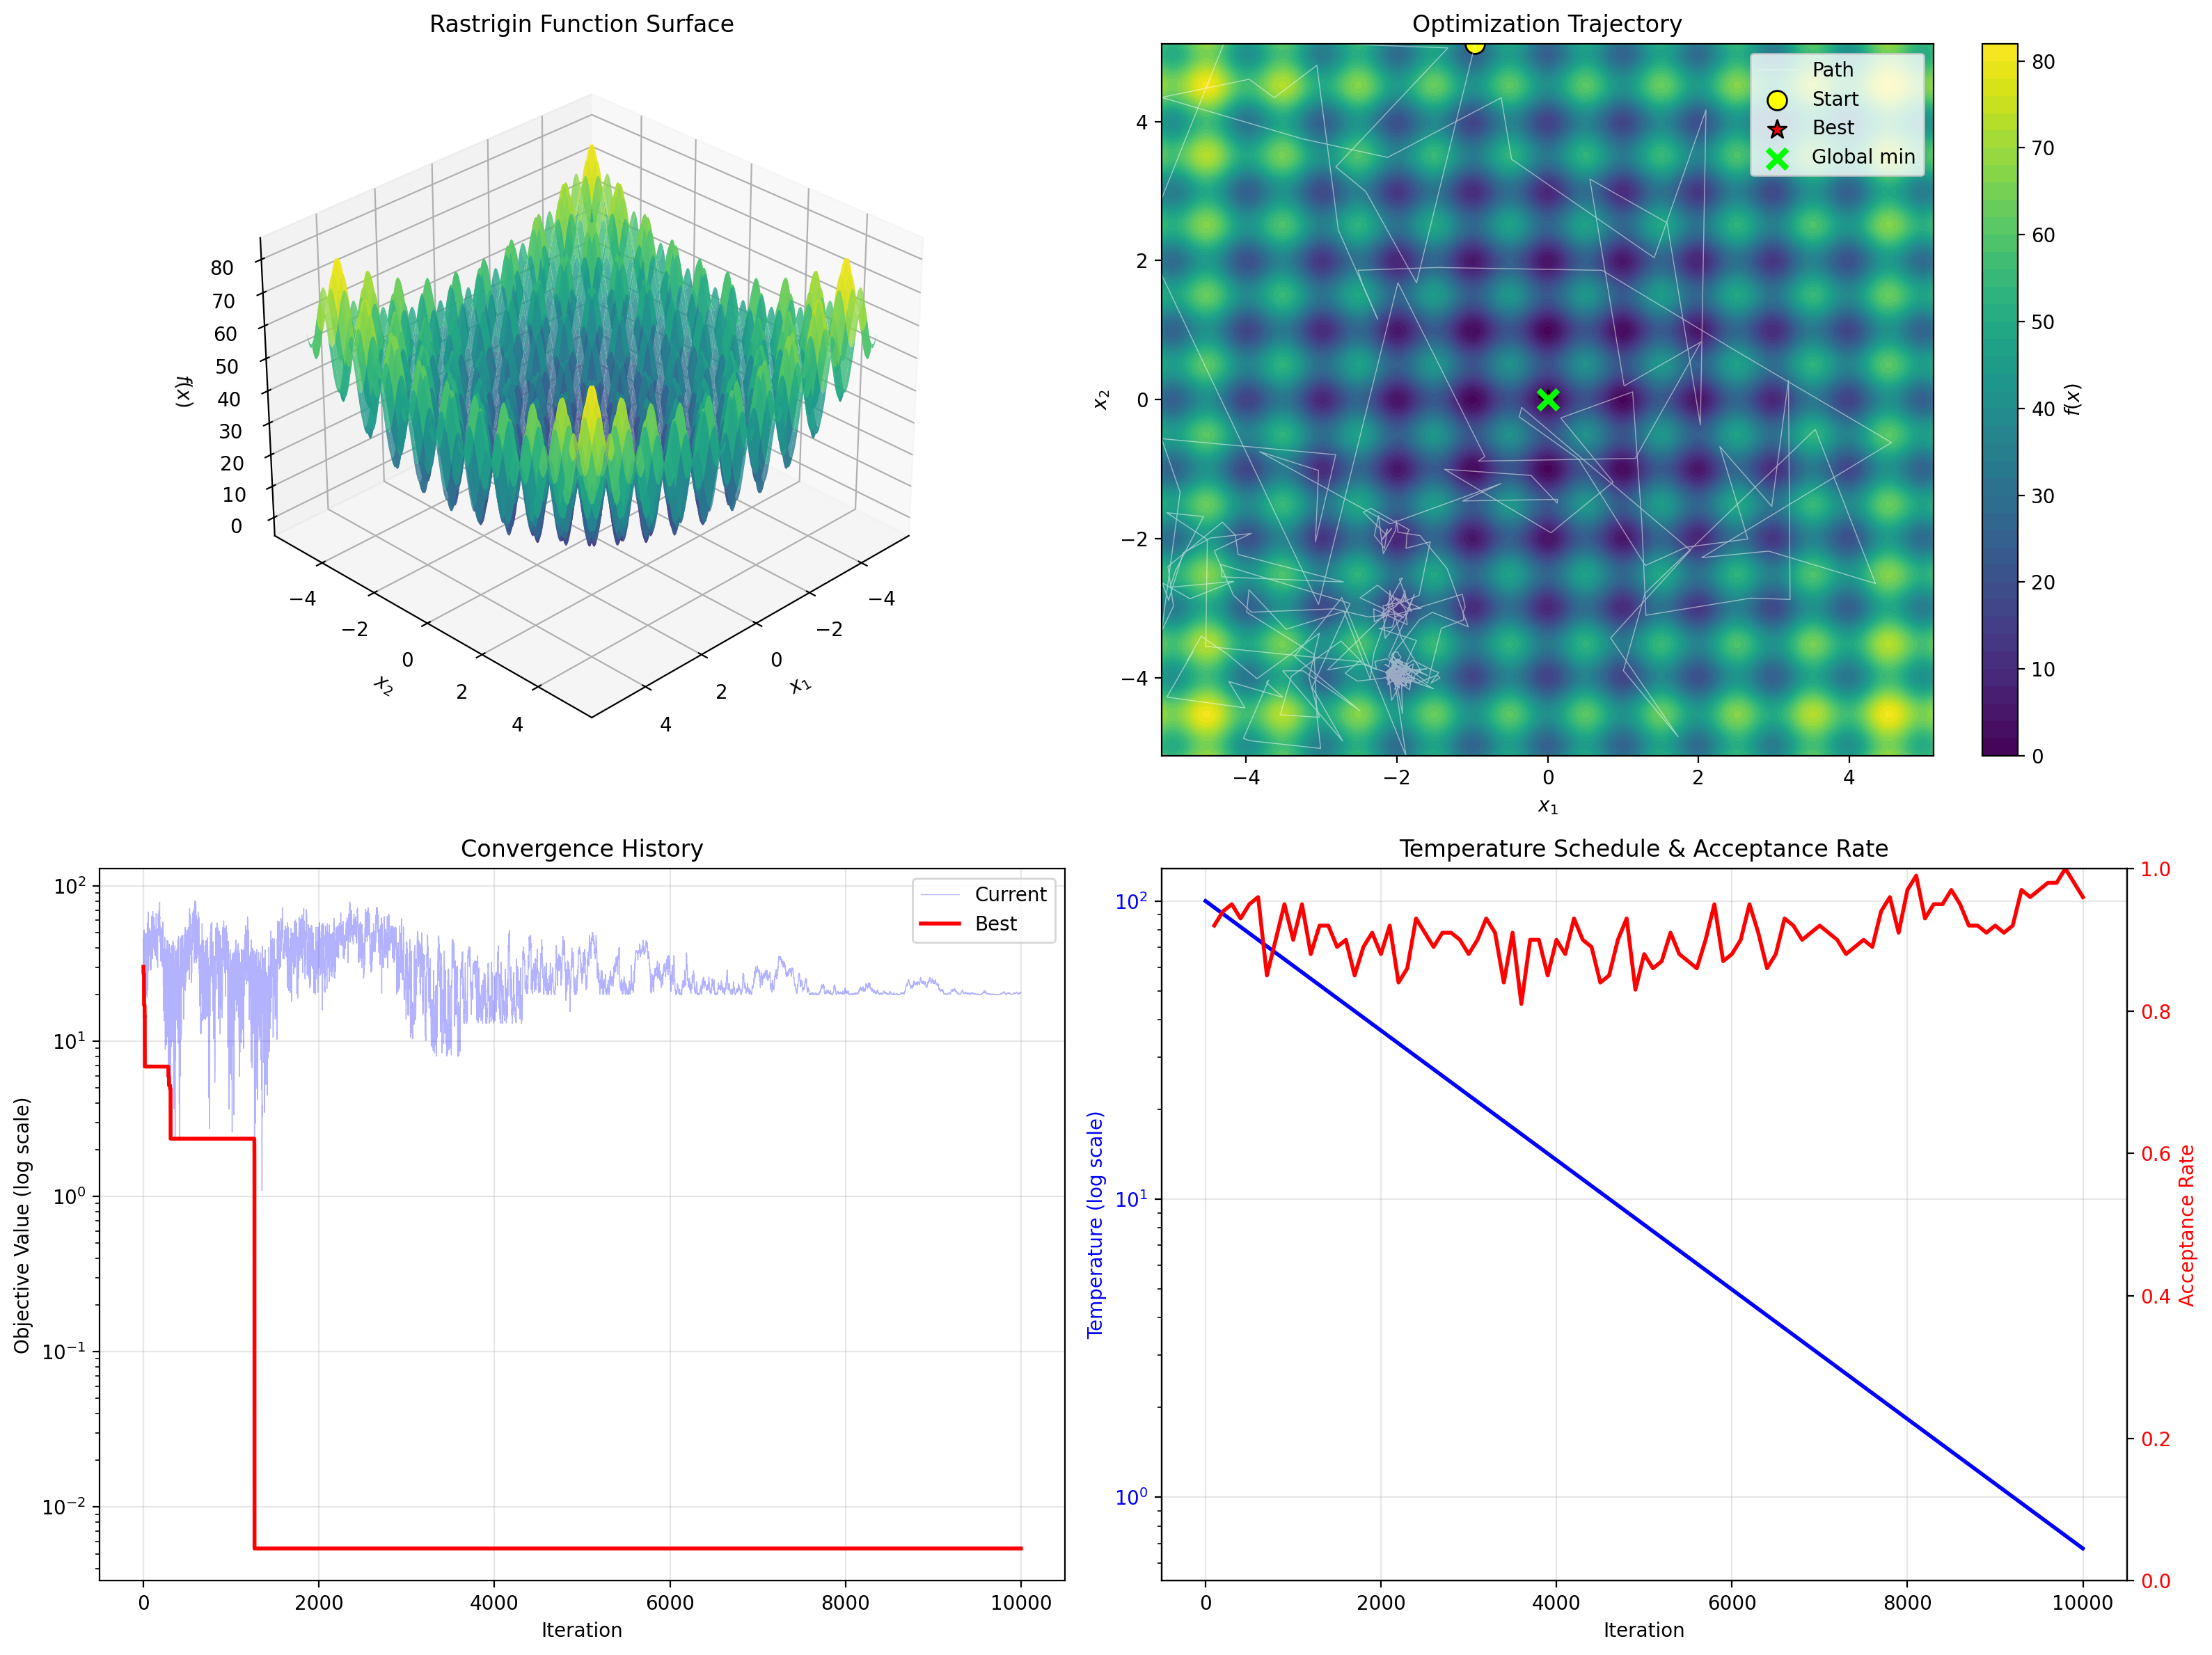


Plot saved to 'plot.png'


In [6]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Plot 1: 3D surface of Rastrigin function
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, 
                        linewidth=0, antialiased=True)
ax1.scatter([best_solution[0]], [best_solution[1]], [best_score], 
           color='red', s=100, marker='*', label='Best found')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$f(x)$')
ax1.set_title('Rastrigin Function Surface')
ax1.view_init(elev=30, azim=45)

# Plot 2: Contour plot with optimization path
ax2 = fig.add_subplot(2, 2, 2)
contour = ax2.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, ax=ax2, label='$f(x)$')

# Plot optimization trajectory
positions = np.array(history['positions'])
# Subsample for clarity
step = max(1, len(positions) // 500)
ax2.plot(positions[::step, 0], positions[::step, 1], 'w-', 
         alpha=0.5, linewidth=0.5, label='Path')
ax2.scatter(positions[0, 0], positions[0, 1], color='yellow', 
           s=100, marker='o', edgecolors='black', label='Start')
ax2.scatter(best_solution[0], best_solution[1], color='red', 
           s=100, marker='*', edgecolors='black', label='Best')
ax2.scatter(0, 0, color='lime', s=100, marker='x', 
           linewidths=3, label='Global min')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title('Optimization Trajectory')
ax2.legend(loc='upper right')

# Plot 3: Convergence history
ax3 = fig.add_subplot(2, 2, 3)
iterations = np.arange(len(history['best_score']))
ax3.semilogy(iterations, history['current_score'], 'b-', 
            alpha=0.3, label='Current', linewidth=0.5)
ax3.semilogy(iterations, history['best_score'], 'r-', 
            linewidth=2, label='Best')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Objective Value (log scale)')
ax3.set_title('Convergence History')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Temperature and acceptance rate
ax4 = fig.add_subplot(2, 2, 4)
ax4_twin = ax4.twinx()

# Temperature
ln1 = ax4.semilogy(iterations, history['temperature'], 'b-', 
                   linewidth=2, label='Temperature')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Temperature (log scale)', color='blue')
ax4.tick_params(axis='y', labelcolor='blue')

# Acceptance rate
if history['acceptance_rate']:
    ar_iterations = np.arange(100, len(history['best_score']) + 1, 100)[:len(history['acceptance_rate'])]
    ln2 = ax4_twin.plot(ar_iterations, history['acceptance_rate'], 'r-', 
                       linewidth=2, label='Acceptance Rate')
    ax4_twin.set_ylabel('Acceptance Rate', color='red')
    ax4_twin.tick_params(axis='y', labelcolor='red')
    ax4_twin.set_ylim(0, 1)

ax4.set_title('Temperature Schedule & Acceptance Rate')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simulated_annealing_optimization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis and Discussion

### Algorithm Behavior

The visualization demonstrates several key characteristics of Simulated Annealing:

1. **Exploration vs. Exploitation**: At high temperatures, the algorithm freely explores the search space, accepting uphill moves that help escape local minima. As temperature decreases, it gradually shifts toward exploitation, refining the solution in promising regions.

2. **Acceptance Rate Decay**: The acceptance rate naturally decreases as temperature drops, reflecting the transition from exploration to exploitation.

3. **Convergence**: The best score monotonically improves (or stays constant), while the current score fluctuates due to accepted uphill moves.

### Parameter Sensitivity

- **Initial Temperature ($T_0$)**: Should be high enough to allow significant exploration initially
- **Cooling Rate ($\alpha$)**: Slower cooling (higher $\alpha$) improves solution quality but increases computation time
- **Number of Iterations**: Must be sufficient to allow convergence at low temperatures

### Comparison with Other Methods

Unlike gradient-based methods, SA:
- Does not require gradient information
- Can escape local minima
- Works on non-differentiable functions
- Provides probabilistic guarantees of global convergence

### Applications

Simulated Annealing finds applications in:
- Combinatorial optimization (TSP, scheduling)
- Machine learning hyperparameter tuning
- Circuit design and VLSI placement
- Protein folding simulations
- Financial portfolio optimization